In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sqlalchemy import create_engine
import warnings

<IPython.core.display.Javascript object>

In [3]:
# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std, X_pca, test_size=0.5, random_state=13579
)

<IPython.core.display.Javascript object>

In [4]:
full_pred = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)

pd.crosstab(y, full_pred)

col_0,0,1
row_0,,
0,50,0
1,0,50
2,0,50


<IPython.core.display.Javascript object>

In [5]:
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric="euclidean"))

0.5817500491982808


<IPython.core.display.Javascript object>

This is due to the fact that there are two classes that are not linearly separable. There is one class that is far and away unique from the other two so it's easy for the model to make that cluster.

In [6]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "heartdisease"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
df = pd.read_sql_query("select * from heartdisease", con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [17]:
df = df.iloc[:-1, :]

<IPython.core.display.Javascript object>

In [18]:
# Define the features and the outcome
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by `?`) with a `0`
X = X.replace(to_replace="?", value=0)

# Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
y = np.where(y > 0, 0, 1)

<IPython.core.display.Javascript object>

In [19]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std, X_pca, test_size=0.5, random_state=13579
)

<IPython.core.display.Javascript object>

In [20]:
X_half2.shape

(151, 13)

<IPython.core.display.Javascript object>

In [21]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([(X_half1, X_pcahalf1), (X_half2, X_pcahalf2)]):

    # Put the features into ypred.
    ypred["pca_f1" + "_sample" + str(counter)] = data[1][:, 0]
    ypred["pca_f2" + "_sample" + str(counter)] = data[1][:, 1]

    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred["clust" + str(nclust) + "_sample" + str(counter)] = pred

<IPython.core.display.Javascript object>

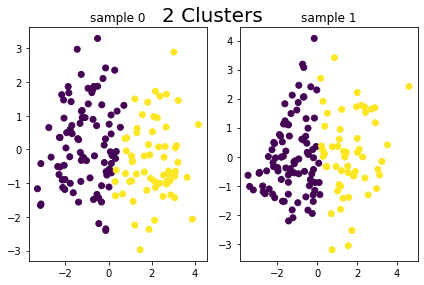

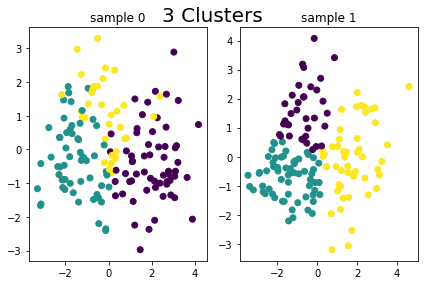

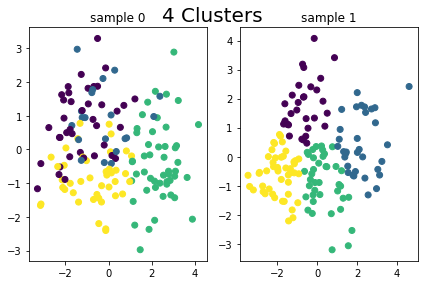

<IPython.core.display.Javascript object>

In [22]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):

    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample.
    for i in range(2):

        # PCA-created features.
        x_sub = ypred["pca_f1_sample{}".format(i)]
        y_sub = ypred["pca_f2_sample{}".format(i)]

        # Cluster assignments.
        c = ypred["clust{}_sample{}".format(cluster, i)]

        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title("sample {}".format(i))

    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle("{} Clusters".format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print("\n")

It really seems like two is the best option here. The others appear to have inconsistent grouping although k=3 might be viable. 4 can safely me removed.

In [24]:
def rand_index_score(grount_truths, predictions):
    tp_plus_fp = scipy.special.comb(np.bincount(grount_truths), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(grount_truths), 2).sum()
    A = np.c_[(grount_truths, predictions)]
    tp = sum(
        scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
        for i in set(grount_truths)
    )
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

<IPython.core.display.Javascript object>

In [29]:
for nclust in range(2, 5):
    full_pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(X_std)
    ri = rand_index_score(y, full_pred)
    ari = metrics.adjusted_rand_score(y, full_pred)
    print(f"For {nclust} clusters the RI is {ri:.2f} and the ARI is {ari:.2f}")

For 2 clusters the RI is 0.75 and the ARI is 0.44
For 3 clusters the RI is 0.48 and the ARI is 0.28
For 4 clusters the RI is 0.37 and the ARI is 0.19


<IPython.core.display.Javascript object>

2 clusters appear to be the best for this model.

In [31]:
for nclust in range(2, 5):
    labels = KMeans(n_clusters=nclust, random_state=123).fit_predict(X_std)
    print(nclust)
    print(metrics.silhouette_score(X_std, labels, metric="euclidean"))

2
0.17440650461256255
3
0.12862190702187828
4
0.1314736248593191


<IPython.core.display.Javascript object>

K=2 still seems to be the best performer of them all.